<a href="https://colab.research.google.com/github/09360990/test/blob/main/%E5%B0%88%E6%A1%882_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#下載Kaggle資料集
api_token = {"username":"moneymoneymoney","key":"801b5f9dc6a76bcbddc3e00cfbf451d2"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.jsonA
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
#!kaggle datasets download -d ma7555/cat-breeds-dataset --force
!kaggle competitions download -c dog-breed-identification

!ls /kaggle

chmod: cannot access '/root/.kaggle/kaggle.jsonA': No such file or directory
100% 688M/691M [00:33<00:00, 19.2MB/s]
100% 691M/691M [00:33<00:00, 21.7MB/s]
dog-breed-identification.zip


In [ ]:
!unzip cat-breeds-dataset.zip #解壓縮

串流輸出內容已截斷至最後 5000 行。
  inflating: images/Tortoiseshell/46495717_25061.jpg  
  inflating: images/Tortoiseshell/46495784_25049.jpg  
  inflating: images/Tortoiseshell/46495794_25052.jpg  
  inflating: images/Tortoiseshell/46496797_24946.jpg  
  inflating: images/Tortoiseshell/46497000_24936.jpg  
  inflating: images/Tortoiseshell/46497664_24825.jpg  
  inflating: images/Tortoiseshell/46500078_24567.jpg  
  inflating: images/Tortoiseshell/46504471_24003.jpg  
  inflating: images/Tortoiseshell/46507777_23590.jpg  
  inflating: images/Tortoiseshell/46510043_23381.jpg  
  inflating: images/Tortoiseshell/46510643_23331.jpg  
  inflating: images/Tortoiseshell/46512081_23194.jpg  
  inflating: images/Tortoiseshell/46513326_23056.jpg  
  inflating: images/Tortoiseshell/46513392_23048.jpg  
  inflating: images/Tortoiseshell/46515915_22642.jpg  
  inflating: images/Tortoiseshell/46518048_22389.jpg  
  inflating: images/Tortoiseshell/46518676_22313.jpg  
  inflating: images/Tortoiseshell/46518761_2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import math
import os
import scipy.misc
import PIL.Image
import tensorflow as tf


# 讀csv
df_train = pd.read_csv("/kaggle/data/cats.csv")
# 列出所有品種
breeds_map = list(set(df_train['breed']))

######### 載入數據
#####讀數據
filename_list = df_train['id']
# 將label從名字改為序列號
label_list = [breeds_map.index(label_name) for label_name in df_train['breed']]
# 製作圖片的路徑
for y in breeds_map:
  filename_list = ['/kaggle/images/{}/{}.jpg'.format(y,x) for x in filename_list ]



##### 生成dataset
def preprocess_for_train(image_path, label):
  # 用tf讀圖，并做resize，以及Normalization
  image_string = tf.io.read_file(image_path)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0

  return image_resized, label

# 生成dataset
train_num = int(len(filename_list)*0.9)
train_dataset = tf.data.Dataset.from_tensor_slices((filename_list[:train_num], label_list[:train_num]))
tf.random.set_seed(1) # 設置隨機種子，固定數據的順序
train_dataset = train_dataset.shuffle(len(filename_list[:train_num])).map(preprocess_for_train).batch(1)

val_dataset = tf.data.Dataset.from_tensor_slices((filename_list[train_num:], label_list[train_num:]))
tf.random.set_seed(2)
val_dataset = val_dataset.shuffle(len(filename_list[train_num:])).map(preprocess_for_train).batch(1)

######### 建好數據

######## 配置訓練參數
weight_path = os.path.join("root", "kaggle", "images", "weights")+"/mymodel.ckpt"

num_epochs = 10
learning_rate = 0.01
decay_rate = 1e-6 # 學習率衰減，每輪減少學習率的值
image_shape = (224, 224)
batch_size=40  #一次訓練多少張圖，越大越快，但是對系統內存要求越高,報內存錯誤調低這個值，最小可以到1
n_class = len(breeds_map)
print("有{}個品種".format(n_class))
######## 配置訓練參數完成

########生成模型
#### 模型導入
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Input, concatenate, GlobalAveragePooling2D, Conv2D, BatchNormalization,MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# 載入模型
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(160, 160, 3)))

vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(
    shape=(image_shape[0], image_shape[1], 3)), classes=n_class)
res50 = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=Input(
    shape=(image_shape[0], image_shape[1], 3)), classes=n_class)

#### 模型组合(vgg16+res50)
class MyModel(tf.keras.Model):
    def __init__(self, n_class=2):
        super().__init__()
        self.vgg16_model = vgg16
        self.res50_model = res50
        self.global_pool = GlobalAveragePooling2D()
        self.conv_vgg = Dense(512/4, use_bias=False, kernel_initializer='uniform')
        self.conv_res = Dense(2048/4, use_bias=False, kernel_initializer='uniform')
        self.batch_normalize = BatchNormalization()
        self.batch_normalize_res = BatchNormalization()
        self.relu = Activation("relu")
        self.concat = concatenate
        self.dropout_1 = Dropout(0.3)
        self.conv_1 = Dense(640, use_bias=False, kernel_initializer='uniform')
        self.batch_normalize_1 = BatchNormalization()
        self.relu_1 = Activation("relu")
        self.dropout_2 = Dropout(0.3)
        self.classify = Dense(n_class, kernel_initializer='uniform', activation="softmax")

    def call(self, input):
      x_vgg16 = self.vgg16_model(input)
      x_vgg16 = self.global_pool(x_vgg16)
      x_vgg16 = self.conv_vgg(x_vgg16)
      x_vgg16 = self.batch_normalize(x_vgg16)
      x_vgg16 = self.relu(x_vgg16)
      x_res50 = self.res50_model(input)
      x_res50 = self.global_pool(x_res50)
      x_res50 = self.conv_res(x_res50)
      x_res50 = self.batch_normalize_res(x_res50)
      x_res50 = self.relu(x_res50)
      x = self.concat([x_vgg16, x_res50])
      x = self.dropout_1(x)
      x = self.conv_1(x)
      x = self.batch_normalize_1(x)
      x = self.relu_1(x)
      x = self.dropout_2(x)
      x = self.classify(x)
      return x

########導入模型完成

######### 模型訓練部分


model = MyModel(n_class)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, decay=decay_rate)

checkpoint_callback = ModelCheckpoint(
    weight_path, monitor='val_accuracy', verbose=1,
    save_best_only=False, save_weights_only=True,
    save_frequency=1)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
)
model.fit(train_dataset, validation_data=val_dataset,epochs=num_epochs,callbacks=[checkpoint_callback])


######### 訓練模型完成


FileNotFoundError: ignored

In [2]:
!unzip dog-breed-identification.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import math
import os
import scipy.misc
import PIL.Image
import tensorflow as tf

# 读csv
df_train = pd.read_csv("/kaggle/labels.csv")
# 列举所有种类
breeds_map = list(set(df_train['breed']))

######### 加载数据
#####读数据
filename_list = df_train['id']
# 将label从名字改为序列号
label_list = [breeds_map.index(label_name) for label_name in df_train['breed']]
filename_list = ['/kaggle/train/{}.jpg'.format(x) for x in filename_list]


##### 生成dataset
def preprocess_for_train(image_path, label):
  # 用tf读图，并做resize，以及归一化
  image_string = tf.io.read_file(image_path)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0

  return image_resized, label

def preprocess_for_val(image_path, label):
  # 用tf读图，并做resize，以及归一化
  image_string = tf.io.read_file(image_path)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0

  return image_resized, label 

# 生成dataset
train_num = int(len(filename_list)*0.9)
train_dataset = tf.data.Dataset.from_tensor_slices((filename_list[:train_num], label_list[:train_num]))
tf.random.set_seed(1) # 设置随机种子，以后跑的时候固定数据的顺序
train_dataset = train_dataset.shuffle(len(filename_list[:train_num])).map(preprocess_for_train).batch(40)

val_dataset = tf.data.Dataset.from_tensor_slices((filename_list[train_num:], label_list[train_num:]))
tf.random.set_seed(2)
val_dataset = val_dataset.shuffle(len(filename_list[train_num:])).map(preprocess_for_train).batch(40)

######### 数据加载完成

######## 配置训练参数
import os
weight_path = os.path.join("kaggle", "My Drive", "dogs_breeds", "weights")+"/mymodel.ckpt"

num_epochs = 10
learning_rate = 0.01
decay_rate = 1e-6 # 学习率衰减，每轮减少学习率的值
image_shape = (224, 224)
batch_size=40  #一次训练多少张图，越大越快，但是对系统内存要求越高,报内存错误调低这个值，最小可以到1
n_class = len(breeds_map)
print("有{}个种类".format(n_class))
######## 配置训练参数完成

########## 数据查看
# 查看25个狗狗的品种，batchsize设置越大，这里读的越慢，所以这一段可以注释掉。
'''
for image, label in train_dataset.take(1):
  print(image.shape)
  # 若批量设置大于25的话，取这一批的前25个数据。若小于25，则设置为n*n个。
  n=5
  image, label = image[:n*n], label[:n*n]  
  plt.figure(figsize=(10,10))
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(image[i], cmap=plt.cm.binary)
      plt.xlabel(breeds_map[label[i]])
  plt.show()
  '''
#########数据查看部分完成

########模型生成部分
#### 模型导入
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Input, concatenate, GlobalAveragePooling2D, Conv2D, BatchNormalization,MaxPooling2D, Activation, Flatten, Dense
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(
    shape=(image_shape[0], image_shape[1], 3)), classes=n_class)
res50 = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=Input(
    shape=(image_shape[0], image_shape[1], 3)), classes=n_class)

#### 模型组合
class MyModel(tf.keras.Model):
    def __init__(self, n_class=2):
        super().__init__()
        self.vgg16_model = vgg16
        self.res50_model = res50
        self.global_pool = GlobalAveragePooling2D()
        self.conv_vgg = Dense(512/4, use_bias=False, kernel_initializer='uniform')
        self.conv_res = Dense(2048/4, use_bias=False, kernel_initializer='uniform')
        self.batch_normalize = BatchNormalization()
        self.batch_normalize_res = BatchNormalization()
        self.relu = Activation("relu")
        self.concat = concatenate
        self.dropout_1 = Dropout(0.3)
        self.conv_1 = Dense(640, use_bias=False, kernel_initializer='uniform')
        self.batch_normalize_1 = BatchNormalization()
        self.relu_1 = Activation("relu")
        self.dropout_2 = Dropout(0.3)
        self.classify = Dense(n_class, kernel_initializer='uniform', activation="softmax")

    def call(self, input):
      x_vgg16 = self.vgg16_model(input)
      x_vgg16 = self.global_pool(x_vgg16)
      x_vgg16 = self.conv_vgg(x_vgg16)
      x_vgg16 = self.batch_normalize(x_vgg16)
      x_vgg16 = self.relu(x_vgg16)
      x_res50 = self.res50_model(input)
      x_res50 = self.global_pool(x_res50)
      x_res50 = self.conv_res(x_res50)
      x_res50 = self.batch_normalize_res(x_res50)
      x_res50 = self.relu(x_res50)
      x = self.concat([x_vgg16, x_res50])
      x = self.dropout_1(x)
      x = self.conv_1(x)
      x = self.batch_normalize_1(x)
      x = self.relu_1(x)
      x = self.dropout_2(x)
      x = self.classify(x)

      return x

########模型导入部分完成

######### 模型训练部分
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

model = MyModel(n_class)
# 加载之前训练过的模型可以加快收敛速度，第一次训练需要注释掉
# model.load_weights(weight_path)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, decay=decay_rate)

checkpoint_callback = ModelCheckpoint(
    weight_path, monitor='val_accuracy', verbose=1,
    save_best_only=False, save_weights_only=True,
    save_frequency=1)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
)
model.fit(train_dataset, validation_data=val_dataset,epochs=num_epochs,callbacks=[checkpoint_callback])

######### 模型训练完成


有120个种类
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
230/230 [==============================] - ETA: 0s - loss: 4.4007 - sparse_categorical_accuracy: 0.0931
Epoch 1: saving model to kaggle/My Drive/dogs_breeds/weights/mymodel.ckpt
230/230 [==============================] - 264s 1s/step - loss: 4.4007 - sparse_categorical_accuracy: 0.0931 - val_loss: 4.9192 - val_sparse_categorical_accuracy: 0.0098
Epoch 2/10
230/230 [==============================] - ETA: 0s - loss: 3.0008 - sparse_categorical_accuracy: 0.3790
Epoch 2: saving model to kaggle/My Drive/dogs_breeds/weights/mymodel.ckpt
230/230 [==============================] - 226s 982ms/step - loss: 3.0008 - sparse_categorical_accuracy: 0.3790 - val_loss: 4.8529 - val_sparse_categorical_accuracy: 0.0137
Epoch 3/10
230/230 [==============================] - ETA: 0s - loss: 2.0565 - sparse_categorical_accuracy: 0.5723
Epoch 3: saving model to kaggle/My Drive/dogs_breeds/weights/mymodel.ckpt
230/230 [========

1/1 [==============================] - 2s 2s/step
預測結果爲appenzeller


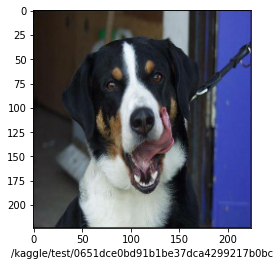

In [4]:
import cv2
import tensorflow as tf
#model.load_weights(weight_path+'mymodel_20191113.ckpt')
#image_path = "/kaggle/test/000621fb3cbb32d8935728e48679680e.jpg" # 輸入的圖片路徑
#image_path = "/kaggle/test/002c58d413a521ae8d1a5daeb35fc803.jpg" # 輸入的圖片路徑
#image_path = "/kaggle/test/0068f3a21b159ece126a28580cdad7a0.jpg" # 輸入的圖片路徑
#image_path = "/kaggle/test/01335e3d4849ec81cc1578aa915227b9.jpg" # 輸入的圖片路徑
#image_path = "/kaggle/test/01d5ffa4de01074483149bec0f6e5a59.jpg" # 輸入的圖片路徑
image_path = "/kaggle/test/0651dce0bd91b1be37dca4299217b0bc.jpg" # 輸入的圖片路徑

def preprocess_for_train(image_path):
  # 用tf讀圖，並做resize，以及歸一化
  image_string = tf.io.read_file(image_path)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
  image_resized = tf.expand_dims(image_resized, 0)

  return image_resized


image = preprocess_for_train(image_path)
pred = model.predict(image)
pred = np.argmax(pred)
y_pred = breeds_map[pred]
print("預測結果爲{}".format(y_pred))
plt.imshow(image[0], cmap=plt.cm.binary)
plt.xlabel(image_path.split('.')[0])
plt.show()

In [ ]:
########## 数据查看
# 查看25个狗狗的品种，batchsize设置越大，这里读的越慢，所以这一段可以注释掉。

for image, label in train_dataset.take(1):
  print(image.shape)
  # 若批量设置大于25的话，取这一批的前25个数据。若小于25，则设置为n*n个。
  n=5
  image, label = image[:n*n], label[:n*n]  
  plt.figure(figsize=(10,10))
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(image[i], cmap=plt.cm.binary)
      plt.xlabel(breeds_map[label[i]])
  plt.show()
